<a href="https://colab.research.google.com/github/DhawalV1/ReinforcementLearningSim/blob/main/sol2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gymnasium

In [5]:

import numpy as np
from PIL import Image
import cv2
import pdb

class Grid:

    def __init__(self,
        locations = dict(),
        N=10):

        self.B = 3
        self.color = [0.2588, 0.4039, 0.6980]
        self.brightness = 1.8
        self.grid = []
        self.P = 5
        self.W = 100
        self.M = N
        self.N = N
        self.ew = self.W + self.P//2

        self.locations = locations
        self.icons = dict()
        for i in self.locations:
            self.icons[i] = self.load_image(f"images/{i}.png")

        #generate the grid
        self.grid = self.generate_grid()

    def load_image(self, path):

        image = Image.open(path)
        image = cv2.resize(np.array(image), (self.W,self.W))
        image = image.astype('float') / 255
        return image

    def get_real_coordinates(self, i, j):

        x = j
        y = self.N - 1 - i
        return (x,y)

    def put_icon(self, grid, icon):

        gg = icon[:,:,3:]*icon[:,:,:3]
        grid[self.P//2:-1*self.P//2, self.P//2:-1*self.P//2] = gg + (1-icon[:,:,3:])*grid[self.P//2:-1*self.P//2, self.P//2:-1*self.P//2]
        return grid

    def generate_grid(self):
        grid = []

        #iterate over each grid cell
        for i in range(self.M):

            #the row
            row_i = []

            #for each row
            for j in range(self.N):

                #the i and j th grid cell
                grid_ij = np.ones((self.W+self.P, self.W+self.P, 3))

                #paint with colors
                for c in range(3):
                    grid_ij[:,:,c] = self.color[c]*(0.7 + (self.brightness - 0.9)/60*(i+30-j))

                #see if any icon should be here
                real_coordinates = self.get_real_coordinates(i,j)
                for k in self.locations:
                    if(real_coordinates in self.locations[k]):
                        grid_ij = self.put_icon(grid_ij, self.icons[k])

                #make white
                grid_ij[:self.P//2,:,:] = 0
                grid_ij[-self.P//2:,:,:] = 0

                grid_ij[:,:self.P//2,:] = 0
                grid_ij[:,-self.P//2:,:] = 0

                #append to row_i
                row_i.append(grid_ij)

            #append to grid
            grid.append(row_i)
        return grid

    def get_grid(self, x, y):
        grid = self.grid[self.M - y - 1][x]
        return grid

    def draw_one_step_grid(self, sp, dp, grid, color):
        #print(sp, dp)
        if(sp[0] == dp[0]):

            grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1],:] *= 0
            for c in range(3):
                grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1],c] = color[c]
            #print(grid[sp[0]-self.P//2:dp[0] + self.P//2, sp[1]:dp[1],0].shape)
        else:
            grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2,:] *= 0
            for c in range(3):
                grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2,c] = color[c]
            #print(grid[sp[0]:dp[0], sp[1]-self.P//2:dp[1] + self.P//2,0].shape)

    def draw_one_step(self, sp, dp, color):

        delta_x = dp[0] - sp[0]
        delta_y = dp[1] - sp[1]

        sgrid = self.get_grid(sp[0]-1, sp[1]-1)
        dgrid = self.get_grid(dp[0]-1, dp[1]-1)
        if(delta_x == delta_y):
            return
        if(delta_x == -1):
            self.draw_one_step_grid((self.ew//2 + 1,0),(self.ew//2 + 1, self.ew//2+1), sgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.ew//2+1,self.W + self.P), dgrid, color)

        elif(delta_x == 1):
            self.draw_one_step_grid((self.ew//2+1, 0),(self.ew//2 + 1, self.ew//2 + 1), dgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.ew//2+1, self.W + self.P), sgrid, color)
        elif(delta_y == -1):
            self.draw_one_step_grid((0 ,self.ew//2 + 1),( self.ew//2 + 1, self.ew//2+1), dgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.W + self.P, self.ew//2+1), sgrid, color)

        elif(delta_y == 1):
            self.draw_one_step_grid((0, self.ew//2+1),(self.ew//2 + 1, self.ew//2 + 1), sgrid, color)
            self.draw_one_step_grid((self.ew//2 + 1, self.ew//2 + 1),(self.W + self.P,self.ew//2+1), dgrid, color)

        return

    def draw_path(self, sequence, color = [0,0,1]):

        start_x, start_y = sequence[0]
        start_grid = self.get_grid(start_x-1,start_y-1)
        start_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2] *= 0
        start_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2,0] += 1


        end_x, end_y = sequence[-1]
        end_grid = self.get_grid(end_x-1,end_y-1)
        end_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2] *= 0
        end_grid[self.P//2:-1*self.P//2,self.P//2:-1*self.P//2,1] += 1

        for i in range(1,len(sequence)):
            self.draw_one_step(sequence[i-1],sequence[i], color)


    # def draw_arrow(self, x, y, direction):




    def show(self, path = "demo.png", return_image = False):

        grid = [np.concatenate(row_i, axis = 1) for row_i in self.grid]
        grid = np.concatenate(grid, axis = 0)
        grid = np.clip(grid, 0, 1)
        grid_big = np.zeros((grid.shape[0] + 2*self.B, grid.shape[1] + 2*self.B, 3))
        grid_big[:,:,0] = 1
        grid_big[:,:,1] = 1
        grid_big[self.B:-1*self.B,self.B:-1*self.B] = grid

        grid = (grid_big*255).astype('uint8')
        if(return_image):
            return grid
        grid = Image.fromarray(grid)
        grid.save(path)

    def clear(self):
        self.grid = self.generate_grid()

# locations = {
#     'ship': [(0,0)],
#     'land': [(3,0),(3,1),(3,2),(4,2),(4,1),(5,2),(0,7),(0,8),(0,9),(1,7),(1,8),(2,7)],
#     'fort': [(9,9)],
#     'pirate': [(4,7),(8,5)],
#     'treasure': [(4,0),(1,9)],
#     'arrow': [(3,1)],
# }
# tt = Grid(locations)
# tt.show()

In [105]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pdb
# from grid import Grid
from PIL import Image
import imageio
from tqdm import tqdm



UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3

class TreasureHunt():

    def __init__(self, locations):

        self.locations = locations

        #the grid size
        self.n = 10
        self.num_treasures = len(self.locations['treasure'])
        self.num_states = self.n*self.n*(2**self.num_treasures)
        self.num_actions = 4
        self._action_delta = [[0,1],[0,-1],[-1,0],[1,0]]
        self.action_name = ['up','down','left','right']

        #the observation and action space
        self.observation_space = spaces.Discrete(self.num_states)
        self.action_space = spaces.Discrete(self.num_actions)

        #the 0th state
        self.state = 0

        #the treasure indicator
        self.treasure_from_index, self.index_from_treasure = self._get_treasure_indicator()

        #get transition matrix
        self.T = self._generate_tmatrix()

        #the reward matrix
        self.reward = self._generate_reward()

    def reset(self):
        self.state = np.random.randint(self.num_states)
        return self.state

    def locations_from_state(self, state):

        treasure_index = state // 100
        treasure_indicator = self.treasure_from_index[treasure_index]
        treasure_locations = []
        for i in range(self.num_treasures):
            if(treasure_indicator[i] == '1'):
                treasure_locations.append(self.locations['treasure'][i])
        ship_location = state % 100
        ship_location = (ship_location // 10, ship_location % 10)
        return ship_location, treasure_locations

    def _get_treasure_indicator(self):

        treasure_indicator = []
        treasure_index = dict()
        for n in range(2**self.num_treasures):

            treasure_indicator_n = bin(n)[2:][::-1]
            treasure_indicator_n = treasure_indicator_n + ''.join(['0' for i in range(self.num_treasures - len(treasure_indicator_n))])
            treasure_indicator.append(treasure_indicator_n)

            treasure_index[treasure_indicator_n] = n
        return treasure_indicator, treasure_index


    def _get_pos_ts(self, x, y):

        out = np.arange(0, 2**self.num_treasures)
        if((x,y) in self.locations['treasure']):
            ind = self.locations['treasure'].index((x,y))
            for i in range(2**self.num_treasures):
                tind = self.treasure_from_index[i]
                if(tind[ind] == '1'):
                    tind = list(tind)
                    tind[ind] = '0'
                    tind = ''.join(tind)
                    out[i] = self.index_from_treasure[tind]
        return out

    def step(self, action):
      reward = self.reward[self.state]
      next_state = self.T[self.state, action]
      self.state = np.random.multinomial(1, next_state).nonzero()[0][0]
      return self.state, reward


    def is_land(self, x, y):
        return ((x,y) in self.locations['land'])


    def _get_grid_locations(self, state_id):

        locations = dict()
        treasure_index = state_id // (self.n*self.n)
        state_id = state_id % (self.n*self.n)

        x, y = state_id // self.n, state_id % self.n

        locations['pirate'] = self.locations['pirate']
        locations['fort'] = self.locations['fort']
        locations['ship'] = [(x,y)]
        locations['land'] = self.locations['land']
        locations['treasure'] = []
        treasure_indicator = self.treasure_from_index[treasure_index]
        for i in range(self.num_treasures):
            if((x,y) == self.locations['treasure'][i]):
                continue
            if(treasure_indicator[i] == '0'):
                continue
            locations['treasure'].append(self.locations['treasure'][i])
        return locations

    def render(self, state_id = None, path = 'state.jpeg', return_image = True):
        if(state_id is None):
            state_id = self.state
        locations = self._get_grid_locations(state_id)
        grid = Grid(locations)
        if(return_image):
            image = grid.show(return_image = True)
            return image

    def visualize_policy_execution(self, policy, path = 'output.gif'):
        self.state = (2**self.num_treasures - 1)*self.n*self.n
        images = [self.render(return_image = True)]
        for i in tqdm(range(100)):
            action = np.argmax(policy[self.state])
            self.state, _ = self.step(action)
            images.append(self.render(return_image = True))

        pil_images = [Image.fromarray(arr.astype('uint8')) for arr in images]
        imageio.mimsave(path, pil_images, duration=2)

    def get_policy_rewards(self, policy):
        self.state = (2**self.num_treasures - 1)*self.n*self.n
        rewards = []
        for i in range(100):
            action = np.argmax(policy[self.state])
            self.state, reward = self.step(action)
            rewards.append(reward)

        return np.array(rewards)




    def visualize_policy(self, policy, path = 'policy_vis.png'):

        for i in range(2**self.num_treasures):
            state_id = i*self.n*self.n
            policy_i = policy[state_id: state_id + self.n*self.n]
            locations = self._get_grid_locations(state_id)
            del locations['ship']
            policy_i = policy_i.argmax(-1).reshape(self.n, self.n)

            for j in range(4):
                policy_ij = (policy_i == j).nonzero()
                policy_ij = [(x,y) for x,y in zip(policy_ij[0], policy_ij[1])]
                locations[f'{self.action_name[j]}_arrow'] = policy_ij

            grid = Grid(locations)
            pathi = path.split('.')
            pathi = pathi[:-1] + [f"_{i}"] + [pathi[-1]]
            pathi = '.'.join(pathi)
            grid.show(pathi)


    def _generate_tmatrix(self):

        T = np.zeros((2**self.num_treasures, self.n, self.n, self.num_actions, 2**self.num_treasures, self.n, self.n))
        for x in range(self.n):
            for y in range(self.n):

                #if wall then ignore
                if(self.is_land(x,y)):
                    for i in range(2**self.num_treasures):
                        T[i,x,y,:,i,x,y] = 1
                    continue


                #it there is treasure at x,y then change the state
                pos_ts = self._get_pos_ts(x,y)

                #iterate over actions
                for a in range(4):

                    #the prob to distribute
                    prob = 1

                    #find the new state
                    nx = x + self._action_delta[a][0]
                    ny = y + self._action_delta[a][1]

                    #is valid?
                    if(nx < self.n and nx >= 0 and ny < self.n and ny >= 0):
                        if(not self.is_land(nx,ny)):
                            for i in range(2**self.num_treasures):
                                T[i,x,y,a,pos_ts[i],nx,ny] = 0.9
                            prob -= 0.9


                    #now to distribute find all valid states
                    valid_states = [(x,y)]
                    for a_v in range(4):

                        #ignore the desired stated
                        if(a_v == a):
                            continue

                        nx = x + self._action_delta[a_v][0]
                        ny = y + self._action_delta[a_v][1]
                        #if valid append
                        if(nx < self.n and nx >= 0 and ny < self.n and ny >= 0):
                            if(self.is_land(nx,ny)):
                                continue
                            valid_states.append((nx, ny))

                    #distribute the probability
                    for (nx,ny) in valid_states:
                        for i in range(2**self.num_treasures):
                            T[i,x,y,a,pos_ts[i],nx,ny] = prob / len(valid_states)

        T[:,self.n-1,self.n-1,:] = 0
        for i in range(2**self.num_treasures):
            T[i,self.n-1,self.n-1,:,i,self.n-1,self.n-1] = 1

        T = T.reshape(self.num_states, 4, -1)
        return T

    def _generate_reward(self):

        reward = np.zeros((2**self.num_treasures,self.n,self.n)) - 0.1
        for i, tloc in enumerate(self.locations['treasure']):
            for j, tind in enumerate(self.treasure_from_index):
                if(tind[i] == '1'):
                    reward[j,tloc[0],tloc[1]] = 2

        for ploc in self.locations['pirate']:
            reward[:,ploc[0],ploc[1]] = -1

        # Heavy penalty for land to discourage getting stuck
        for lloc in self.locations['land']:
          reward[:, lloc[0], lloc[1]] = -6 # Large negative reward to discourage visiting land

        floc = self.locations['fort'][0]
        reward[:,floc[0], floc[1]] = 0.01
        return reward.reshape(-1)


class TreasureHunt_v2:

    def __init__(self, num_treasures = 2, num_pirates = 2, num_lands = 10, locations = None):

        #save the args
        self.num_lands = num_lands
        self.num_pirates = num_pirates
        self.num_treasures = num_treasures

        if(locations is None):
            locations = dict()
            loc = self.sample_random_locations(self.num_treasures, self.num_pirates, self.num_lands)
            locations['treasure'] = loc[:self.num_treasures]
            locations['pirate'] = loc[self.num_treasures: self.num_treasures + self.num_pirates]
            locations['land'] = loc[self.num_pirates + self.num_treasures : ]
            locations['ship'] = [(0,0)]
            locations['fort'] = [(9,9)]

        #make the grid for the pirate and land
        self.land_spatial_state = np.zeros((10,10))
        for x,y in locations['land']:
            self.land_spatial_state[x,y] = 1
        self.pirate_spatial_state = np.zeros((10,10))
        for x,y in locations['pirate']:
            self.pirate_spatial_state[x,y] = 1

        #get the model
        self.env = TreasureHunt(locations)
        self.state = self.index_to_spatial(self.env.state)

    def render(self, state, path = 'state.jpeg', return_image = True):

        state_id = self.spatial_to_index(state)
        image = self.env.render(state_id, path, return_image)
        if(return_image):
            return image

    def visualize_policy_execution(self, policy, path = 'output.gif'):
        self.env.visualize_policy_execution(policy, path)

    def visualize_policy(self, policy, path = 'policy_vis.png'):
        self.env.visualize_policy(policy, path)

    def spatial_to_index(self, state):
        treasure_indicator = []
        for (x,y) in self.env.locations['treasure']:
            if(state[2,x,y] == 1):
                treasure_indicator.append('1')
            else:
                treasure_indicator.append('0')
        treasure_indicator = ''.join(treasure_indicator)
        index = self.env.index_from_treasure[treasure_indicator]
        index = 100*index + np.argmax(state[3])
        return index

    def reset(self):

        loc = self.sample_random_locations(self.num_treasures, self.num_pirates, self.num_lands)
        locations = dict()
        locations['ship'] = [(0,0)]
        locations['fort'] = [(9,9)]
        locations['treasure'] = loc[:self.num_treasures]
        locations['pirate'] = loc[self.num_treasures: self.num_treasures + self.num_pirates]
        locations['land'] = loc[self.num_pirates + self.num_treasures : ]

        #make the grid for the pirate and land
        self.land_spatial_state = np.zeros((10,10))
        for x,y in locations['land']:
            self.land_spatial_state[x,y] = 1
        self.pirate_spatial_state = np.zeros((10,10))
        for x,y in locations['pirate']:
            self.pirate_spatial_state[x,y] = 1

        self.env = TreasureHunt(locations)
        self.env.reset()
        self.state = self.index_to_spatial(self.env.state)
        return self.state

    def index_to_spatial(self, index):
        ship_location, treasure_locations = self.env.locations_from_state(index)
        spatial_state = np.zeros((4, 10, 10))
        spatial_state[0] = self.land_spatial_state
        spatial_state[1] = self.pirate_spatial_state
        for (x,y) in treasure_locations:
            spatial_state[2,x,y] = 1
        spatial_state[3,ship_location[0], ship_location[1]] = 1
        return spatial_state > 0

    def step(self, action):

        nstate_id, r = self.env.step(action)
        self.state = self.index_to_spatial(self.env.state)
        return self.state, r

    def get_policy_rewards(self, policy):
        return self.env.get_policy_rewards(policy)


    def sample_random_locations(self, num_treasures, num_pirates, num_lands):

        locations = []
        possible_locations = np.arange(1,99).tolist()
        locations_id = np.random.choice(possible_locations, num_treasures, replace = False).tolist()
        locations += locations_id

        possible_locations = list(set(possible_locations) - set(locations_id))
        locations_id = np.random.choice(possible_locations, num_pirates, replace = False).tolist()
        locations += locations_id

        possible_locations = list(set(possible_locations) - set(locations_id))
        locations_id = np.random.choice(possible_locations, num_lands, replace = False).tolist()
        locations += locations_id

        loc = []
        for i in locations:
            loc.append((i // 10, i % 10))
        return loc

    def get_all_states(self):

        states = []
        for i in range(self.env.num_states):
            states.append(self.index_to_spatial(i))
        return np.stack(states, axis = 0)

# locations = {
#     'ship': [(0,0)],
#     'land': [(3,0),(3,1),(3,2),(4,2),(4,1),(5,2),(0,7),(0,8),(0,9),(1,7),(1,8),(2,7)],
#     'fort': [(9,9)],
#     'pirate': [(4,7),(8,5)],
#     'treasure': [(4,0),(1,9)]
# }

# th = TreasureHunt(locations)
# T = th.T
# tt = T.sum(-1)
# pdb.set_trace()




In [43]:
len(rewards)

2

In [ ]:
plt.plot(rewards)
plt.title('Rewards vs Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

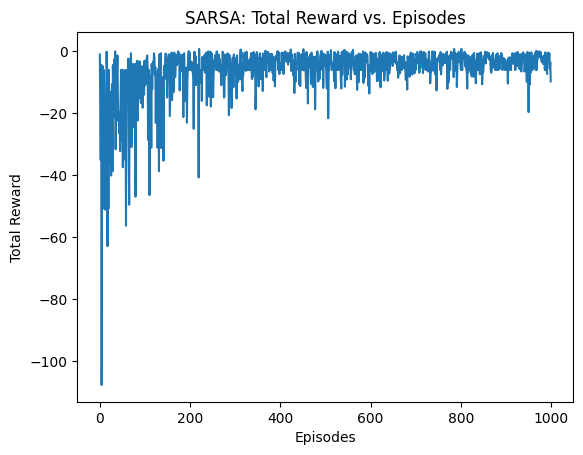

In [106]:
import numpy as np
import random

def epsilon_greedy_policy(Q, state, num_actions, epsilon):
    """
    Choose an action based on an epsilon-greedy policy.
    """
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(num_actions))  # Explore: random action
    else:
        return np.argmax(Q[state])  # Exploit: choose action with highest Q-value

def check_if_reached_fort(env):
    """
    Check if the agent has reached a fort by comparing its position
    with the fort locations in the environment.
    """
    # Convert the current state to grid coordinates (row, col)
    ship_position,_ = env.locations_from_state(env.state)

    # Check if ship's position matches any of the fort locations
    # for fort_location in env.locations['fort']:
    if ship_position == env.locations['fort'][0]:
        return True  # Agent has reached a fort
    return False  # Agent hasn't reached a fort

def sarsa(env, num_episodes, alpha, gamma, epsilon):
    """
    SARSA algorithm for TreasureHunt environment.
    Args:
    - env: The TreasureHunt environment
    - num_episodes: Number of episodes for training
    - alpha: Learning rate
    - gamma: Discount factor
    - epsilon: Epsilon for epsilon-greedy policy
    """
    # Initialize Q-table with zeros
    Q = np.zeros((env.num_states, env.num_actions))

    # List to store total rewards for each episode (for plotting later)
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()  # Reset environment for new episode
        action = epsilon_greedy_policy(Q, state, env.num_actions, epsilon)

        total_reward = 0
        done = False

        while not done:
            # Take action and observe next state and reward
            next_state, reward = env.step(action)

            # Choose next action using epsilon-greedy policy
            next_action = epsilon_greedy_policy(Q, next_state, env.num_actions, epsilon)

            # Update Q-value using SARSA update rule
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

            # Update state and action for the next step
            state = next_state
            action = next_action

            # Accumulate the reward
            total_reward += reward

            # Check if the agent has reached the fort (use the helper function from earlier)
            done = check_if_reached_fort(env)

            if env.locations_from_state(env.state)[0] in env.locations['land']:
              # total_reward -=5
              break
            # print(env.locations_from_state(env.state)[0])
            # print(done)

        # Store the total reward for this episode
        episode_rewards.append(total_reward)

        # Print progress every 100 episodes
        # if episode % 100 == 0:
        # print(f"Episode {episode}, Total Reward: {total_reward}")

    return Q, episode_rewards

# Assuming you have the SARSA hyperparameters and the environment already set up:
alpha = 0.3     # Learning rate
gamma = 0.95    # Discount factor
epsilon = 0.4   # Probability of choosing a random action
num_episodes = 1000
env = TreasureHunt(locations)

# print(env.num_states, env.num_actions)

# Run SARSA on the TreasureHunt environment
Q, rewards = sarsa(env, num_episodes, alpha, gamma, epsilon)

# # Plot the total rewards per episode
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Total Reward vs. Episodes')
plt.show()


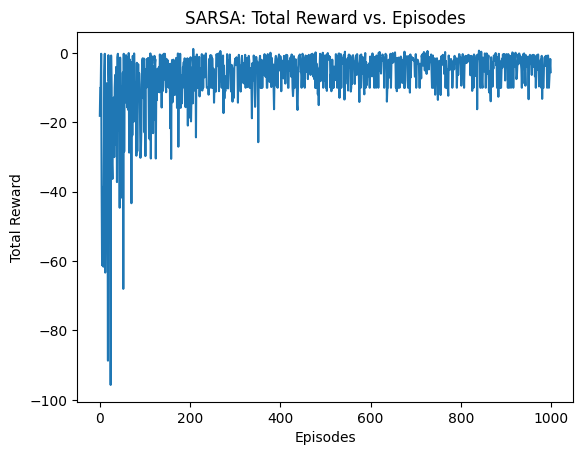

In [82]:
# with mod in env(land code) penalty -10
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('SARSA: Total Reward vs. Episodes')
plt.show()

## Q-Learning

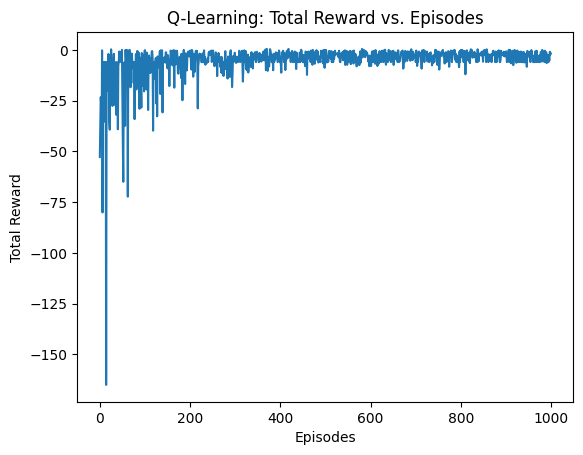

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Q-Learning algorithm
def q_learning(env, num_episodes, alpha=0.3, gamma=0.95, epsilon=0.4):
    """
    Implement Q-Learning algorithm for TreasureHunt environment.

    :param env: Gym-like environment (TreasureHunt)
    :param num_episodes: Number of episodes to train the agent
    :param alpha: Learning rate
    :param gamma: Discount factor
    :param epsilon: Exploration rate
    :return: Trained Q-table and rewards per episode
    """

    # Initialize Q-table with zeros
    Q = np.zeros((env.num_states, env.num_actions))

    # List to store total rewards for each episode
    rewards_per_episode = []

    # Iterate over episodes
    for episode in range(num_episodes):
        state = env.reset()  # Reset environment to start a new episode
        done = False
        total_reward = 0


        while not done:
            # Epsilon-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore: random action
            else:
                action = np.argmax(Q[state])  # Exploit: select the best action based on current Q-values

            next_state, reward = env.step(action)

            total_reward += reward

            # Q-Learning update rule
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

            # Update current state
            state = next_state

            # Check if the episode is done (e.g., agent reaches the fort)
            done = check_if_reached_fort(env)

            if env.locations_from_state(env.state)[0] in env.locations['land']:
              break
            # print(env.locations_from_state(env.state)[0])
            # print(done)

        # Append the total reward for this episode
        rewards_per_episode.append(total_reward)

    return Q, rewards_per_episode


# Parameters
num_episodes = 1000
alpha = 0.3  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 0.4  # Exploration rate

# Run Q-Learning algorithm
Q, rewards1 = q_learning(env, num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)

# Plot the rewards per episode
plt.plot(rewards1)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q-Learning: Total Reward vs. Episodes')
plt.show()


## Taxi_v3

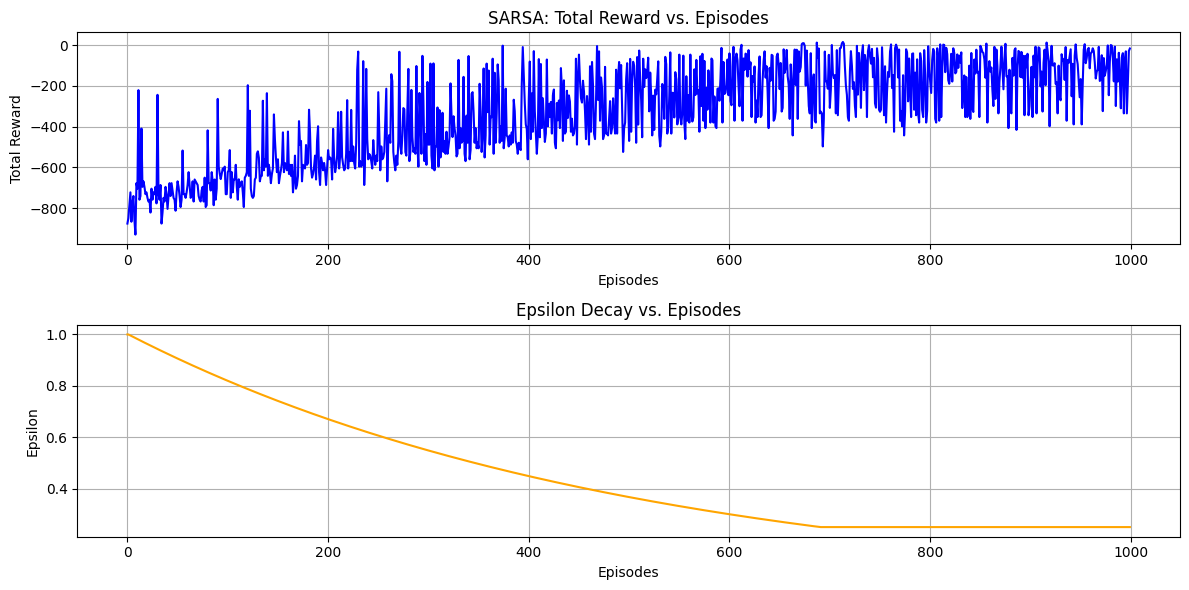

In [115]:
import numpy as np
import gym
import matplotlib.pyplot as plt

# Initialize the Taxi environment
env = gym.make("Taxi-v3")

# Hyperparameters
num_episodes = 1000
alpha = 0.05  # Learning rate
gamma = 0.95  # Discount factor
epsilon_start = 1.0  # Initial epsilon value
epsilon_end = 0.25  # Minimum epsilon value
decay_factor = 0.99  # Decay factor for epsilon
K = 5 # Constant for decay schedule
epsilon = epsilon_start  # Initialize epsilon
Q = np.zeros((env.observation_space.n, env.action_space.n))  # Q-table initialization

# Function to choose action based on epsilon-greedy policy
def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Explore: select a random action
    else:
        return np.argmax(Q[state])  # Exploit: select the action with max Q-value

# Lists to store total rewards and epsilon values per episode
total_rewards = []
epsilons = []

# SARSA algorithm
for episode in range(num_episodes):
    state = env.reset()  # Reset environment for a new episode
    action = choose_action(state, epsilon)  # Choose initial action
    total_reward = 0  # Initialize total reward for this episode
    done = False

    while not done:
        next_state, reward, done, _ = env.step(action)  # Take action
        total_reward += reward  # Accumulate reward

        # Choose the next action based on the next state
        next_action = choose_action(next_state, epsilon)

        # Update Q-value using SARSA update rule
        Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])

        # Update state and action
        state = next_state
        action = next_action

    total_rewards.append(total_reward)  # Record the total reward for this episode
    epsilons.append(epsilon)  # Record the epsilon value for this episode

    # Update epsilon according to the decay function
    epsilon = max(epsilon_start * (decay_factor ** (episode / K)), epsilon_end)

# Save the learned Q-table
np.save("q_table.npy", Q)

# Save the learned policy (greedy policy)
policy = np.argmax(Q, axis=1)
np.save("learned_policy.npy", policy)

# Plot total rewards per episode
plt.figure(figsize=(12, 6))

# Reward vs Episodes
plt.subplot(2, 1, 1)
plt.plot(total_rewards, label='Total Reward', color='blue')
plt.title("SARSA: Total Reward vs. Episodes")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.grid()

# Epsilon vs Episodes
plt.subplot(2, 1, 2)
plt.plot(epsilons, label='Epsilon', color='orange')
plt.title("Epsilon Decay vs. Episodes")
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.grid()

plt.tight_layout()
plt.show()

# Close the environment
env.close()


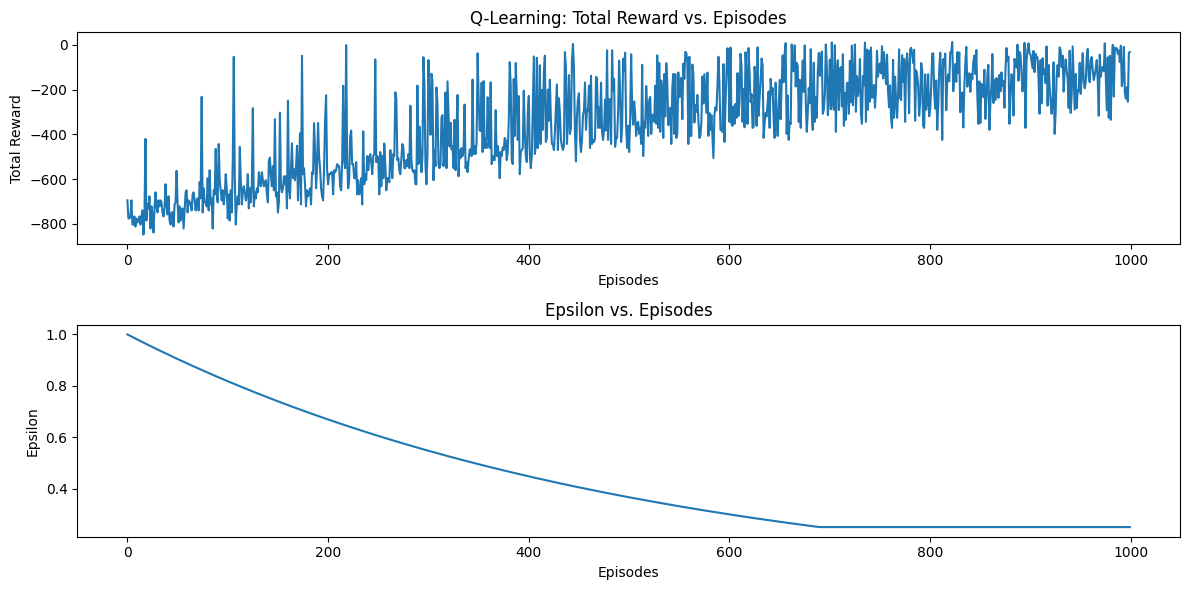

In [124]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pickle  # For saving the Q-table and policy

# Hyperparameters
epsilon_start = 1.0  # Initial epsilon value
epsilon_end = 0.25  # Minimum epsilon value
decay_factor = 0.99  # Decay factor for epsilon
K = 5 # Constant for decay schedule
gamma = 0.95         # Discount factor
alpha = 0.05         # Learning rate
num_episodes = 1000  # Total episodes for training

# Initialize the Taxi-v3 environment
env = gym.make("Taxi-v3",new_step_api=False)

# Initialize Q-table
Q = np.zeros((env.observation_space.n, env.action_space.n))

# Function to update epsilon
def update_epsilon(epsilon, episode):
    return max(epsilon_start * (decay_factor ** (episode / K)), epsilon_end)

# Store rewards and epsilon values for plotting
rewards = []
epsilons = []

# Q-Learning algorithm
for episode in range(num_episodes):
    state = env.reset()  # Reset environment and get initial state
    done = False
    total_reward = 0
    epsilon = update_epsilon(epsilon_start, episode)  # Update epsilon for the episode

    while not done:
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore: select a random action
        else:
            action = np.argmax(Q[state])  # Exploit: select the action with max Q-value

        # Take action, observe reward and next state
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Q-learning update rule
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

        # Transition to the next state
        state = next_state

    rewards.append(total_reward)
    epsilons.append(epsilon)

# Save the learned Q-table and policy
with open("q_table.pkl", "wb") as f:
    pickle.dump(Q, f)

# Extracting the learned policy (best actions from Q-table)
policy = np.argmax(Q, axis=1)

# Save the policy
with open("policy.pkl", "wb") as f:
    pickle.dump(policy, f)

# Plotting Reward vs. Episodes
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(rewards)
plt.title('Q-Learning: Total Reward vs. Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')

# Plotting Epsilon vs. Episodes
plt.subplot(2, 1, 2)
plt.plot(epsilons)
plt.title('Epsilon vs. Episodes')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')

plt.tight_layout()
plt.show()


In [134]:
import torch
import random
from os import system, name
from time import sleep
import moviepy.editor as mpy
import matplotlib.pyplot as plt

"""Display and evaluate agent's performance"""
# q_table = torch.load("q_table.pkl")
with open('q_table.pkl', 'rb') as f:
    q_table = pickle.load(f)
env = gym.make("Taxi-v3",new_step_api=False)
Traj=[]

total_reward,total_steps=0,0
display_episodes=5
for i_episode in range(display_episodes):
    state = env.reset()
    rewards,steps= 0,0
    done = False
    frames = []
    frame = env.render()
    frames.append(frame)  # Collect frames for visualization.

    while not done:
        action = np.argmax(q_table[state]).item()  # Use PyTorch to select the best action.
        state, reward, done, truncated = env.step(action)
        frame = env.render()
        frames.append(frame)  # Collect frames for visualization.
        steps+=1
        rewards+=reward
        # if(len(Traj)>500):
        #     break
    frame_rate = 1  # You can adjust this
    clip = mpy.ImageSequenceClip(frames, fps=frame_rate)
    clip.write_videofile(f"FrozenLake_NonSlippery_{i_episode}.mp4", codec="libx264")
    total_reward+=rewards
    total_steps+=steps
print(f"Results after {display_episodes} episodes:")
print(f"Average timesteps per episode: {total_steps / display_episodes}")
print(f"Average reward per episode: {total_reward / display_episodes}")


AttributeError: 'NoneType' object has no attribute 'shape'

In [129]:
q_table.shape

  and should_run_async(code)



(500, 6)

In [132]:
env.reset()

488